In [1]:
import sys
sys.path.append("v2_Assignment_Codes")  # Add the folder to the search path

#load data
from v2_data import get_fixed_data
from PriceProcess import price_model
from WindProcess import wind_model
from utils import generate_time_series,generate_experiment_series

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyomo.environ import *
from mdp import check_feasibility,sim_MDP_exp, sim_MDP, generate_scenarios

%load_ext autoreload
%autoreload 2


In [2]:
data = get_fixed_data()
T = data['num_timeslots']

In [3]:
# ensure we always use the same time series for all tasks and experiments
prices,winds = generate_experiment_series()

# Task 4

In [4]:
import random

np.random.seed(42)
random.seed(42)

E = 20

## Evaluate the policies 

In [5]:
from mdp import dummy_policy, sim_optimal_in_hindsight, MultiStagePolicy, ADPPolicy, sample_representative_state_pairs, ValueFunction,backward_value_approx


### Dummy Policy

In [6]:
mean_dummy, costs_dummy = sim_MDP(E,dummy_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:00<00:00, 11963.22it/s]


### Optimal-in-hindsight solution

In [7]:
mean_oih, costs_oih = sim_optimal_in_hindsight(E,winds,prices)

Simulating OIH: 100%|██████████| 20/20 [00:01<00:00, 14.35it/s]


### Stochastic programming policy for 4 configurations

In [8]:
results = np.zeros((4,E))

multi_state_policy = MultiStagePolicy(L=2,k=99)
_, results[0,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=3,k=8)
_, results[1,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=4,k=3)
_, results[2,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=6,k=2)
_, results[3,:] = sim_MDP(E,multi_state_policy,winds,prices)


Simulating MDP: 100%|██████████| 20/20 [02:51<00:00,  8.56s/it]


### Expected value policy

In [35]:
expected_value_policy = MultiStagePolicy(L=24,k=1)
mean_ev, costs_ev = sim_MDP(E,expected_value_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [01:08<00:00,  3.40s/it]


### ADP Policy

In [6]:
# fit value function
state_pairs = sample_representative_state_pairs(100)
V = backward_value_approx(ValueFunction(data['num_timeslots'],7),state_pairs,40,data)

t=23
2151.8784010818904
194.31788944731662
t=22
2324.3214762972657
124.74630651679152
t=21
2322.9079071231013
179.10649965029924
t=20
2664.8215211073466
150.7042088981632
t=19
2688.7140615931426
74.82048910084897
t=18
3238.3390872275027
106.2055500548539
t=17
3324.8635358950055
63.340512868255125
t=16
3004.3829210669605
57.52540842007317
t=15
2958.6735468810984
169.98060510773558
t=14
2841.2003498921795
131.86324022179733
t=13
2456.5313381200253
235.08839750051447
t=12
2754.4507851954386
490.9895193770303
t=11
3318.892987914893
335.638707006378
t=10
5062.639522873068
735.8436340304198
t=9
6326.016550524214
849.6316286479149
t=8
8282.870677097533
956.8586675331879
t=7
7568.938677510023
953.5125848174274
t=6
7778.0968310655535
723.6474441699625
t=5
8282.891082825632
594.2137611081929
t=4
9471.511448710797
1776.314340599798
t=3
5883.073580331102
955.2469370536796
t=2
3961.3486176418137
263.44935042032245
t=1
2399.9951283330774
21.030127573598623
t=0
1152.890660607064
100.36510190175899


In [7]:
# evaluate policy
adp_policy = ADPPolicy(V, data)
mean_adp, costs_adp = sim_MDP(E,adp_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


In [36]:
import os
import pickle

# Ensure the "results" folder exists
os.makedirs("results", exist_ok=True)

# Load existing results if the file exists
results_file = "results/results_data.pkl"
if os.path.exists(results_file):
    with open(results_file, "rb") as file:
        results_data = pickle.load(file)
else:
    results_data = {}

# Prepare the data to save (override or add new values)
optional_values = {
    "mean_dummy": mean_dummy if 'mean_dummy' in locals() else None,
    "costs_dummy": costs_dummy if 'costs_dummy' in locals() else None,
    "mean_oih": mean_oih if 'mean_oih' in locals() else None,
    "costs_oih": costs_oih if 'costs_oih' in locals() else None,
    "mean_ev": mean_ev if 'mean_ev' in locals() else None,
    "costs_ev": costs_ev if 'costs_ev' in locals() else None,
    "mean_adp": mean_adp if 'mean_adp' in locals() else None,
    "costs_adp": costs_adp if 'costs_adp' in locals() else None,
    "results": results if 'results' in locals() else None,
    "data": data if 'data' in locals() else None,
    "prices": prices if 'prices' in locals() else None,
    "winds": winds if 'winds' in locals() else None,
    "state_pairs": state_pairs if 'state_pairs' in locals() else None
}

# Filter out None values
filtered_values = {key: value for key, value in optional_values.items() if value is not None}

# Update the results data
results_data.update(filtered_values)

# Save the updated data to the file
with open(results_file, "wb") as file:
    pickle.dump(results_data, file)

print(f"Results saved to '{results_file}'")

Results saved to 'results/results_data.pkl'


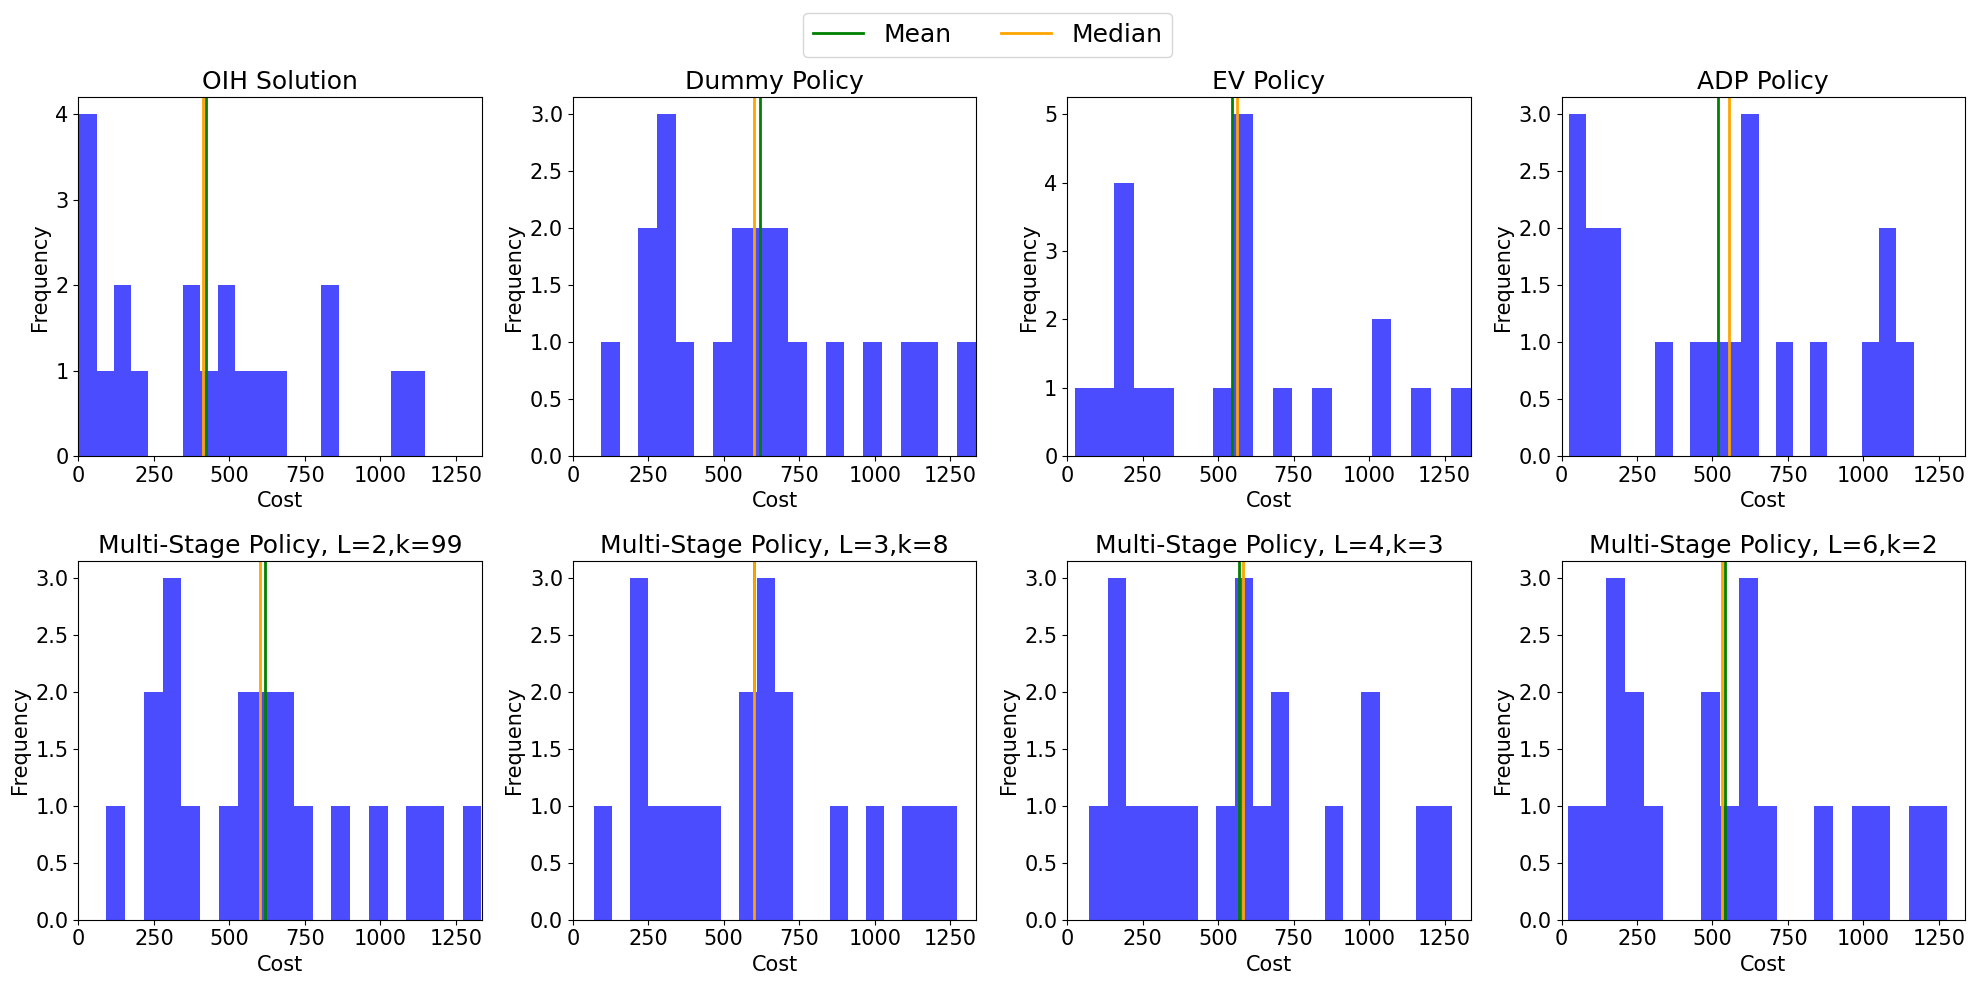

In [39]:
import pickle

# Load the results data from the file
with open("results/results_data.pkl", "rb") as file:
    results_data = pickle.load(file)

# Extract the necessary data
costs_dummy = results_data["costs_dummy"]
costs_oih = results_data["costs_oih"]
costs_ev = results_data["costs_ev"]
costs_adp = results_data["costs_adp"]
results = results_data["results"]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Define a common range for the x-axis
common_xlim = (0, max(max(costs_dummy), max(costs_oih), max(costs_ev), max(costs_adp), results.max()))

# Define consistent colors for histograms and lines
hist_color = 'blue'
mean_color = 'green'
median_color = 'orange'

# First row: Dummy, OIH, EV, and ADP policies
for i, (costs, title) in enumerate(zip(
    [costs_oih, costs_dummy, costs_ev, costs_adp],
    ["OIH Solution", "Dummy Policy", "EV Policy", "ADP Policy"]
)):
    axes[0, i].hist(costs, bins=20, color=hist_color, alpha=0.7)
    axes[0, i].axvline(np.mean(costs), color=mean_color, linewidth=2, label='Mean')
    axes[0, i].axvline(np.median(costs), color=median_color, linewidth=2, label='Median')
    axes[0, i].set_title(title)
    axes[0, i].set_xlabel("Cost")
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].set_xlim(common_xlim)

config = ["L=2,k=99", "L=3,k=8", "L=4,k=3", "L=6,k=2"]

# Second row: Multi-state policies for 4 configurations
for i in range(4):
    axes[1, i].hist(results[i, :], bins=20, color=hist_color, alpha=0.7)
    axes[1, i].axvline(np.mean(results[i, :]), color=mean_color, linewidth=2, label='Mean')
    axes[1, i].axvline(np.median(results[i, :]), color=median_color, linewidth=2, label='Median')
    axes[1, i].set_title(f"Multi-Stage Policy, {config[i]}")
    axes[1, i].set_xlabel("Cost")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].set_xlim(common_xlim)

# Add a common legend
handles = [
    plt.Line2D([0], [0], color=mean_color, linewidth=2, label='Mean'),
    plt.Line2D([0], [0], color=median_color, linewidth=2, label='Median')
]
fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=18)
plt.tight_layout(rect=[0, 0.00, 1, 0.95])  # Adjust layout to make space for the legend
plt.savefig("figures/policy_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
methods = {
    "Dummy Policy": costs_dummy,
    "OIH Policy": costs_oih,
    "EV Policy": costs_ev,
    "ADP Policy": costs_adp,
    "Multi-State Policy (L=2, k=99)": results[0, :],
    "Multi-State Policy (L=3, k=8)": results[1, :],
    "Multi-State Policy (L=4, k=3)": results[2, :],
    "Multi-State Policy (L=6, k=2)": results[3, :]
}

for method, costs in methods.items():
    mean = np.mean(costs)
    std = np.std(costs)
    print(f"{method}: Mean = {mean:.2f}, Std = {std:.2f}")
    

print("------ ordered by mean cost -------")
# Sort the methods by their mean cost
sorted_methods = sorted(methods.items(), key=lambda x: np.mean(x[1]))

# Print the sorted methods with their mean and standard deviation
for method, costs in sorted_methods:
    mean = np.mean(costs)
    std = np.std(costs)
    print(f"{method}: Mean = {mean:.2f}, Std = {std:.2f}")

Dummy Policy: Mean = 618.46, Std = 331.41
OIH Policy: Mean = 421.44, Std = 342.30
EV Policy: Mean = 547.33, Std = 368.41
ADP Policy: Mean = 517.20, Std = 374.24
Multi-State Policy (L=2, k=99): Mean = 618.46, Std = 331.41
Multi-State Policy (L=3, k=8): Mean = 599.51, Std = 336.55
Multi-State Policy (L=4, k=3): Mean = 569.79, Std = 346.07
Multi-State Policy (L=6, k=2): Mean = 542.23, Std = 360.41
------ ordered by mean cost -------
OIH Policy: Mean = 421.44, Std = 342.30
ADP Policy: Mean = 517.20, Std = 374.24
Multi-State Policy (L=6, k=2): Mean = 542.23, Std = 360.41
EV Policy: Mean = 547.33, Std = 368.41
Multi-State Policy (L=4, k=3): Mean = 569.79, Std = 346.07
Multi-State Policy (L=3, k=8): Mean = 599.51, Std = 336.55
Multi-State Policy (L=2, k=99): Mean = 618.46, Std = 331.41
Dummy Policy: Mean = 618.46, Std = 331.41
